# ttH experiment: inference results

## Setup

In [1]:
%matplotlib inline

import sys
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import torch
from torch.utils.data import TensorDataset
import logging
import corner

sys.path.append("../../")

logging.basicConfig(
    format="%(asctime)-5.5s %(name)-30.30s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.DEBUG,
)
logger = logging.getLogger(__name__)
# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "manifold_flow" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)


## Load results

In [4]:
algo_filenames = [
    "flow_20_tth",
    "flow_2_tth2d",
    #"pie_20_tth",
    #"mf_20_tth",
    #"gamf_20_tth",
]
algo_labels = [
    "Summary stats",
    "Flow",
    #"PIE",
    #"MAD AF",
    #"MAD AF (adv)",
]
algo_colors = [
    "0.6",
    "0.6",
    #"C1",
    #"C3",
    #"C0",
]
algo_markers = [
    "o",
    "s",
    #"s",
    #"s",
    #"s",
]
algo_linestyles = [
    "--",
    "-",
    #"-",
    #"-",
    #"-",
]

In [5]:
result_dir = "../data/results"

def load(name, shape, numpyfy=True, result_dir="../data/results"):
    results = []
    for algo_filename in algo_filenames:
        try:
            results.append(np.load(
                "{}/{}_{}.npy".format(
                    result_dir, algo_filename, name
                )
            ))
        except FileNotFoundError as e:
            print(e)
            results.append(np.nan*np.ones(shape))
            
    return np.asarray(results) if numpyfy else results

model_posterior_samples = load("model_posterior_samples", (1000,3,))
model_test_log_likelihood = load("model_log_likelihood_test", (11*11, 1000,))
model_test_reco_error = load("model_reco_error_test", (1000,))
parameter_grid = load("parameter_grid_test", (11*11,2))


In [6]:
model_expected_nll = -2. * np.mean(model_test_log_likelihood, axis=-1)

n_observed = 20
model_observed_nll = -2. * np.sum(model_test_log_likelihood[:,:,:n_observed], axis=-1)

In [7]:
filename = "../data/samples/tth2d/{}.npy"
x_train = np.load(filename.format("x_train"))[::1000]
params_train = np.load(filename.format("theta_train"))[::1000]
x_test = np.load(filename.format("x_test"))[::10]


## Plot data

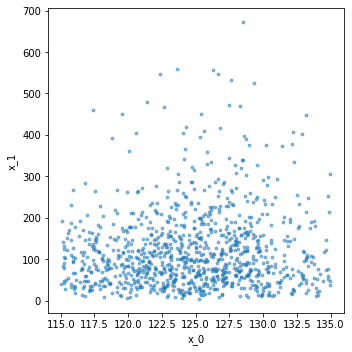

In [8]:
fig = plt.figure(figsize=(5,5))

plt.scatter(x_test[:,0], x_test[:,1], s=8., alpha=0.5, c="C0")

plt.xlabel("x_0")
plt.ylabel("x_1")

plt.tight_layout()
plt.show()

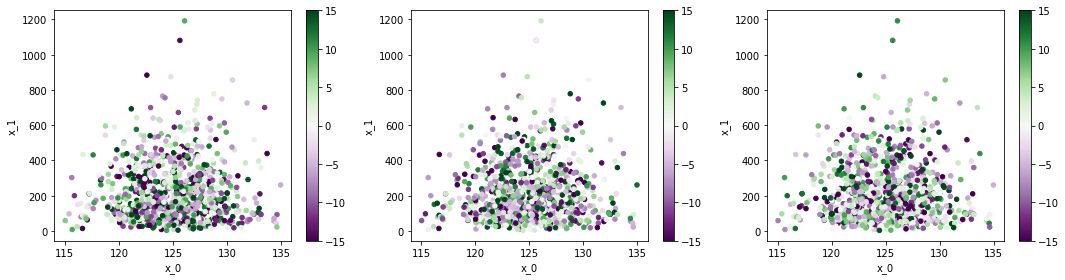

In [17]:
fig = plt.figure(figsize=(15,4))

for i in range(3):
    ax = plt.subplot(1,3,i+1)
    sc = plt.scatter(x_train[:,0], x_train[:,1], s=20., c=params_train[:, i], cmap="PRGn", vmin=-15., vmax=15)
    
    cbar = plt.colorbar(sc)
    
    plt.xlabel("x_0")
    plt.ylabel("x_1")

plt.tight_layout()
plt.show()

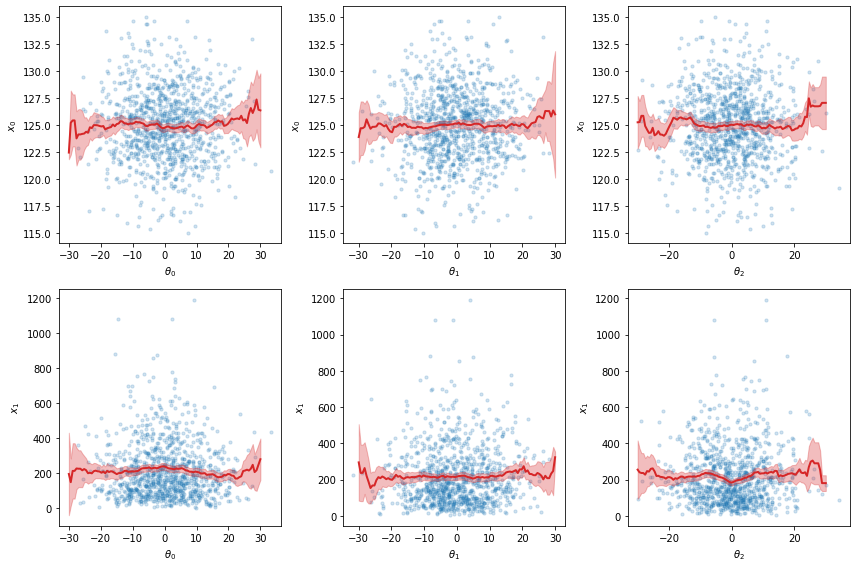

In [18]:
fig = plt.figure(figsize=(12,8))

for j in range(2):
    for i in range(3):
        ax = plt.subplot(2,3,j*3+i+1)
        plt.scatter(params_train[:, i], x_train[:,j], s=10., alpha=0.2)

        thetas = np.linspace(-30., 30., 101)
        x_means = np.array([np.mean(x_train[(params_train[:,i] - theta)**2 < 4**2][:,j]) for theta in thetas])
        x_stds = np.array([np.std(x_train[(params_train[:,i] - theta)**2 < 4**2][:,j] / np.sum((params_train[:,i] - theta)**2 < 4**2)**0.5) for theta in thetas])
        plt.fill_between(thetas, x_means - 2*x_stds, x_means + 2*x_stds, color="C3", alpha=0.3)
        plt.plot(thetas, x_means, lw=2., c="C3")

        plt.xlabel(r"$\theta_{}$".format(i))
        plt.ylabel("$x_{}$".format(j))

plt.tight_layout()
plt.show()

## Likelihood maps

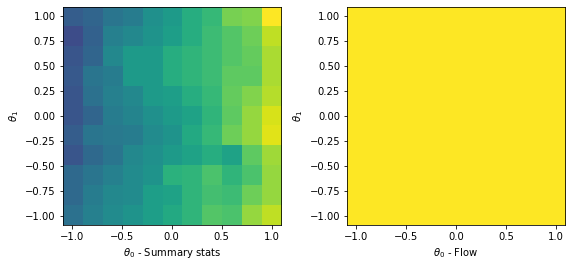

In [19]:
cmin, cmax = 0.,4.

ncols = 3
nrows = (len(algo_labels) - 1) // ncols + 1

fig = plt.figure(figsize=(ncols*4, nrows*4))

for panel, algo in enumerate(range(len(algo_labels))):
    logp = model_expected_nll[algo].reshape((11,11,11))[:, :, 5]
    logp = logp - np.min(logp)
    logp = np.clip(logp, cmin, cmax)

    ax = fig.add_subplot(nrows, ncols, panel + 1)
    extent = (-1. - 0.5 * 2. / 11, 1. + 0.5 * 2. / 11, -1. - 0.5 * 2. / 11, 1. + 0.5 * 2. / 11)
    im = plt.imshow(logp.T, extent=extent, vmin=cmin, vmax=cmax, origin="lower", cmap="viridis_r")

    ax.set_xlabel(r"$\theta_0$ - {}".format(algo_labels[algo]))
    ax.set_ylabel(r"$\theta_1$")

plt.tight_layout()
plt.savefig("../figures/test_expected_likelihood_maps_tth.pdf")



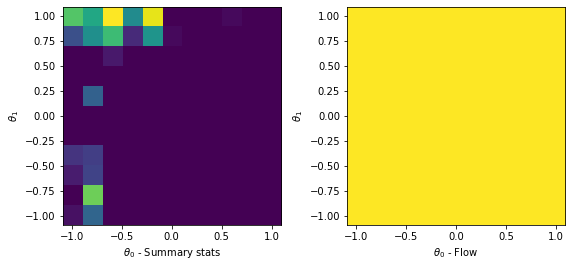

In [20]:
cmin, cmax = 0.,4.*n_observed

ncols = 3
nrows = (len(algo_labels) - 1) // ncols + 1

fig = plt.figure(figsize=(ncols*4, nrows*4))

for panel, algo in enumerate(range(len(algo_labels))):
    logp = model_observed_nll[algo].reshape((11,11,11))[:, :, 5]
    logp = logp - np.min(logp)
    logp = np.clip(logp, cmin, cmax)

    ax = fig.add_subplot(nrows, ncols, panel + 1)
    extent = (-1. - 0.5 * 2. / 11, 1. + 0.5 * 2. / 11, -1. - 0.5 * 2. / 11, 1. + 0.5 * 2. / 11)
    im = plt.imshow(logp.T, extent=extent, vmin=cmin, vmax=cmax, origin="lower", cmap="viridis_r")

    ax.set_xlabel(r"$\theta_0$ - {}".format(algo_labels[algo]))
    ax.set_ylabel(r"$\theta_1$")

plt.tight_layout()
plt.savefig("../figures/test_observed_likelihood_maps_tth.pdf")




## Plot MCMC results

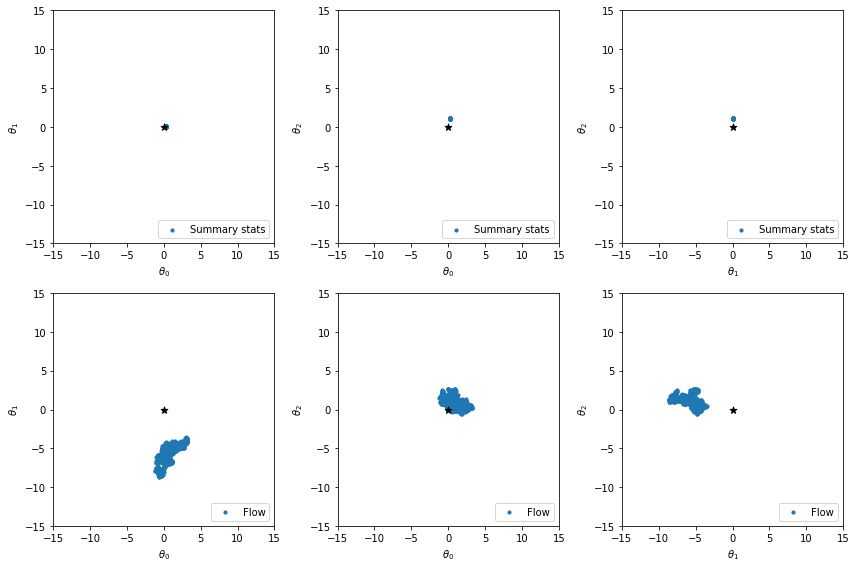

In [21]:
ncols = 3
nrows = len(algo_filenames)

fig = plt.figure(figsize=(ncols*4, nrows*4))

for algo, label in enumerate(algo_labels):
    for i, (ix, iy) in enumerate([(0,1), (0,2), (1,2)]):
        ax = plt.subplot(nrows, ncols, algo*3 + i + 1)
        plt.scatter(model_posterior_samples[algo,:,ix], model_posterior_samples[algo,:,iy], s=10., c="C0", label=label)
        plt.scatter([0.], [0.], s=50, marker="*", c="black")
        plt.legend(loc="lower right")
        
        plt.xlabel(r"$\theta_{}$".format(ix))
        plt.ylabel(r"$\theta_{}$".format(iy))
        plt.xlim(-15,15)
        plt.ylim(-15,15)
    
plt.tight_layout()
plt.savefig("../figures/posterior_samples_tth.pdf")


## Plot histogram of distance from ground truth